In [18]:
options(warn=-1)
library(ggplot2)
library(tidydata)
library(tidydata)
library(ggextra)
set.seed(6203)

ERROR: Error in library(tidydata): there is no package called ‘tidydata’


## Team Members

* Aaditya Vinnakota (Aaditya316) 
* Bao Vo (baovo022293) 
* Frank Corrao (fcorrao) 
* Michael Obin (Obin_michael)
* Nicholas Coyle (nscoyle) 

## Project Overview

### Goals

The goal of our analysis is to identify stock attributes and performance trends which are indicative of resilience during economic downturns. To do so, we leverage data for securities in the S&P 500 during several ‘down markets’ - identifying the stocks which outperform the market and analyzing the traits they have in common (e.g. industry, company size, etc). 

### Approach 

The metric we use to identify outperformance is Jensens Alpha.  We run a standard Jensen's Alpha regression:





For each period, we identify the top 30% of positive alpha stocks and code them as outperformers.  This output beceomes the target of a 
logistic regression to identify features predective of that good performance:




Variables that survive backwards-selection and are statistically significant will be deemed features that predict outperformance.


### Initial Hypothesis

Through this research, we have formed several hypotheses about which types of companies might outperform in recession. We have identified two papers, (Woszczyk 2019) and (Ozkan 2009), which explore investment strategy during economic downturns. Researchers suggest that ‘vice stocks’ tend to outperform as folks resort to ‘bad habits’ (e.g. drinking, smoking, gambling) during times of unemployment Sources 2 (Ozkan 2009).
They also find that healthcare companies are resilient, as demand can be relatively inelastic for medical care (Woszczyk 2019).

## Overview of Data

Most of the data for this analysis was from sources that were relatively clean. The key componets we needed for the analysis:

* For identifying outperformers
  * Data to identify recessionary periods
  * Stock and index returns
  * Index components
* For identiying attributes that predict outperformance
  * Stock specific attributes (industry, common factor exposures, etc)
  * Macroeconomic factors

### Identifying recessions

We observice market performance during several recession periods in the United States as idenfitied by the [Federal Reserve GDP based recession indicator](https://fred.stlouisfed.org/series/JHDUSRGDPBR).

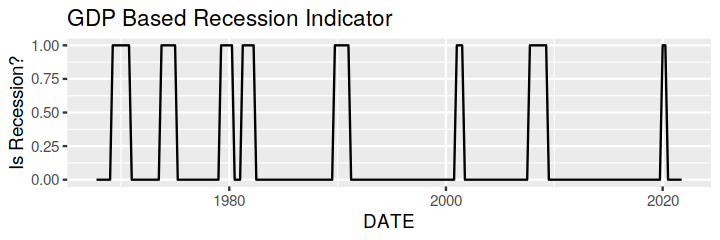

In [23]:
options(repr.plot.width=6, repr.plot.height=2)
is_recession <- read.csv('../Data/JHDUSRGDPBR.csv')
is_recession$DATE <- as.Date(is_recession$DATE)
ggplot(is_recession, aes(x=DATE,y=JHDUSRGDPBR)) + geom_line() + ylab('Is Recession?') + ggtitle("GDP Based Recession Indicator") 

Due to limitations in access to historical data, we evalute performance to the three most recent recessions:

* January 2001 - October 2001
* December 2007 - June 2009
* January 2020 - September 2020

### Stock returns

Corporate action adjusted stock and index prices were pulled from yahoo via the tidyquant R package. From this data, monthly returns were calculated.  S&P500 Index components were idenfied from publicly available sources.

### Stock specific attributes and Macroeconomic factors

Stock sectors were pulled from Yahoo via tidyquant.  Macroeconomic factors such as interest rate and unemployment rate were pulled from Federal Reserve Bank of St. Louis (FRED), also via tidyquant. 

## Overview of Modeling

### Identifying outperformers

### Identifying predictors of outperformance

### Findings

### Challenges and Future Direction

There are several key challenges that must be overcome to make these results more robust and realistic:

1.  Limited Historical Data: as our access to historical S&P 500 data was limited, we could only evaluate three
recession periods. Further, within those recession periods, there were some individual stocks for which data was
unavailable (e.g. for the 2001 recession period, we only had data for 340 stocks in the S&P 500). We did our best
to mitigate this by using code to track the changes in the S&P 500 listed in wikipedia
2.  Limited Operational Performance Data: operational performance data (e.g. market cap, operating income,
profit margin) may have been useful in predicting resilience during downturns. However, access to this data
required significant investment
3.  Non-stationarity: long periods of time between recessions means the patterns we find in our training data
may simply no longer exist due to naturally changing market and macroeconomic dynamics
             
Other additional directions may be to try feature engineering of existing data, identification of technical features that predict outperformance and introcution of alternative classifers to logistic regression, such as tree based methods.

## Conclusion

## Sources



1.  Woszczyk K, 2019, ‘Do mutual funds invest in recession-proof industries prior to
crisis?’, MSc thesis, Erasmus University Rotterdam, Rotterdam [(link)](https://thesis.eur.nl/pub/48135/Thesis-final-K-Woszczyk-25.07.pdf)
1.  Ozkan F C, Xiong Y, 2009, ‘Wise Investing: Analysis of the recession-proof sin
stocks’, MBA thesis, Simon Fraser University, British Columbia [(link)](http://summit.sfu.ca/item/709)
1.  Tidyquant, source of stock data (via Yahoo) and macroeconomic times series (via
Fred) [(link)](https://cran.r-project.org/web/packages/tidyquant/vignettes/TQ05-performance-analysis-with-tidyquant.html)
1.  Kaggle, guidance for performing S&P 500 Analysis in R [(link)](https://www.kaggle.com/code/paytonfisher/s-p-500-analysis-using-r/notebook)
1.  Schwab, ‘Macro-economic factors of fundamental analysis’ [(link)](https://www.cnbc.com/advertorial/2018/06/11/macro-economic-factors-of-fundamental-analysis.html)
1.  Stijn Claessens, M. Ayhan Kose, and Marco E. Terrones, 2008, ‘What Happens During Recessions, Crunches and Busts?’ [(link)](https://www.imf.org/external/pubs/ft/wp/2008/wp08274.pdf)
1.  U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/UNRATE, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/UNRATE)
1.  Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [FEDFUNDS], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/FEDFUNDS, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/FEDFUNDS)
1.  Hamilton, James, Dates of U.S. recessions as inferred by GDP-based recession indicator [JHDUSRGDPBR], retrieved from FRED, Federal Reserve
Bank of St. Louis; https://fred.stlouisfed.org/series/JHDUSRGDPBR, July 18, 2022 [(link)](https://fred.stlouisfed.org/series/JHDUSRGDPBR)

## Code